In [14]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%load_ext autoreload
%autoreload 2

In [15]:
DATADIR = Path('data')

# Correlations
Maybe create a correlation matrix for the dataset, see if staying at home correlates significantly with PHQ9

In [16]:
from data_processing import *
import data_processing as dp

def preprocessed_data(TYPE='classification', TARGET='value'): 
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    #mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    #phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, _ = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    combined = dp.rf_preprocess(combined)
    return combined


def plot_correlations(TYPE='classification', TARGET='value'):
    combined = preprocessed_data(TYPE, TARGET)
    corr = combined.iloc[:, 2:] # remove ID and date
    corr = corr.corr().iloc[0, :] # take only correlations with target row (first row)
    corr = corr.sort_values(ascending=False)
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation in the {TYPE} of PHQ9 {TARGET}')
    plt.show()

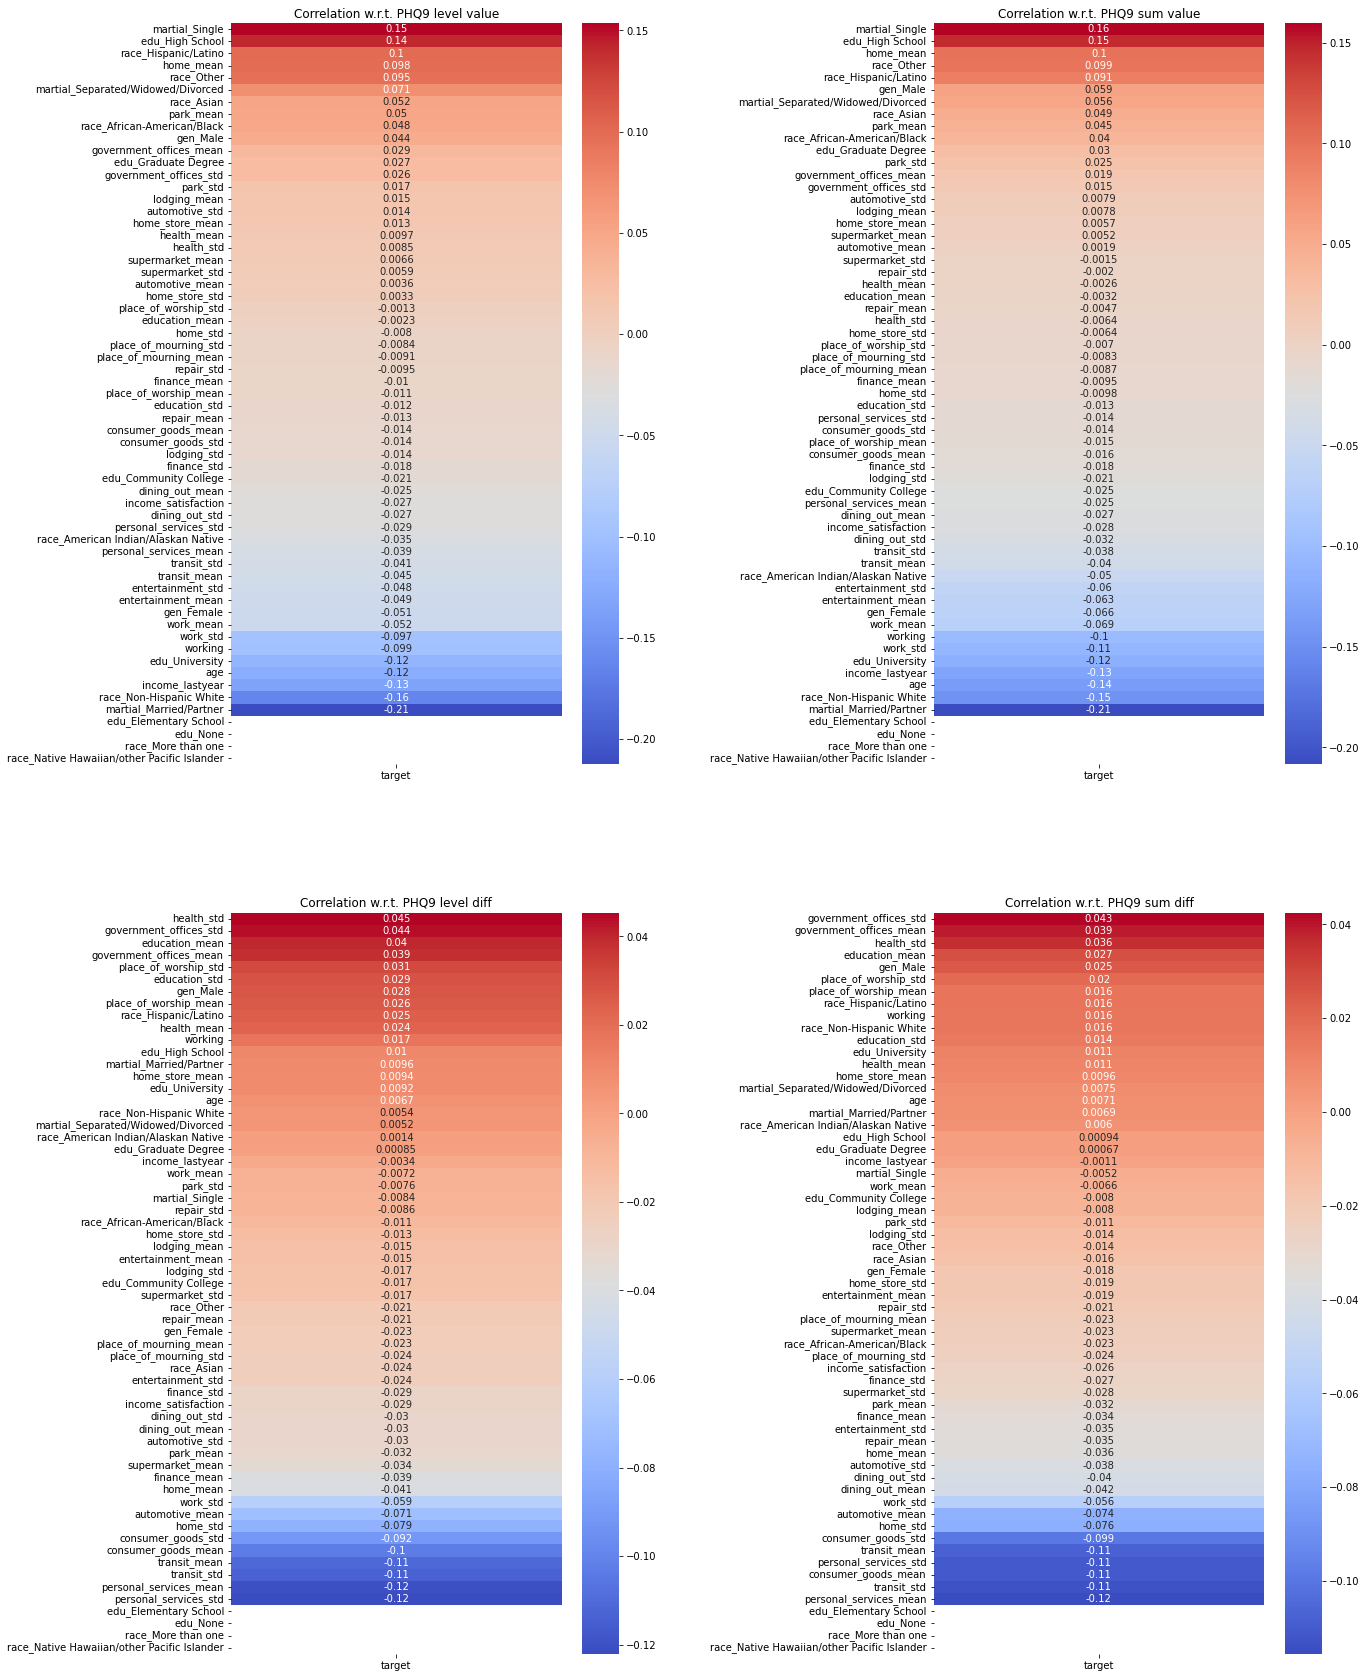

In [4]:
# Create a grid of plots with the four plot_correlations() plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
for i, (TYPE, TARGET) in enumerate([
    ('classification', 'value'), ('regression', 'value'), 
    ('classification', 'diff'), ('regression', 'diff')]):
    combined = preprocessed_data(TYPE, TARGET)
    corr = combined.iloc[:, 2:] # remove ID and date
    corr = corr.corr().iloc[0, :] # take only correlations with target row (first row)
    corr = corr.drop('target').sort_values(ascending=False) # correlation with target is always 1.0
    sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', ax=axes[i // 2, i % 2])
    type_str = 'level' if TYPE == 'classification' else 'sum'
    axes[i // 2, i % 2].set_title(f'Correlation w.r.t. PHQ9 {type_str} {TARGET}')
    # Increase the horizontal spacing between subplots
    fig.subplots_adjust(wspace=0.7)    

# Depression levels (classification)
- 0  :   No depression                  195
- 1-4:   Minimal depression             790
- 5-9:   Mild depression                1760
- 10-14: Moderate depression            1111
- 15-19: Moderately severe depression   624
- 20-27: Severe depression              311

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set accuracy: 94.52%
Test set accuracy:  50.29%


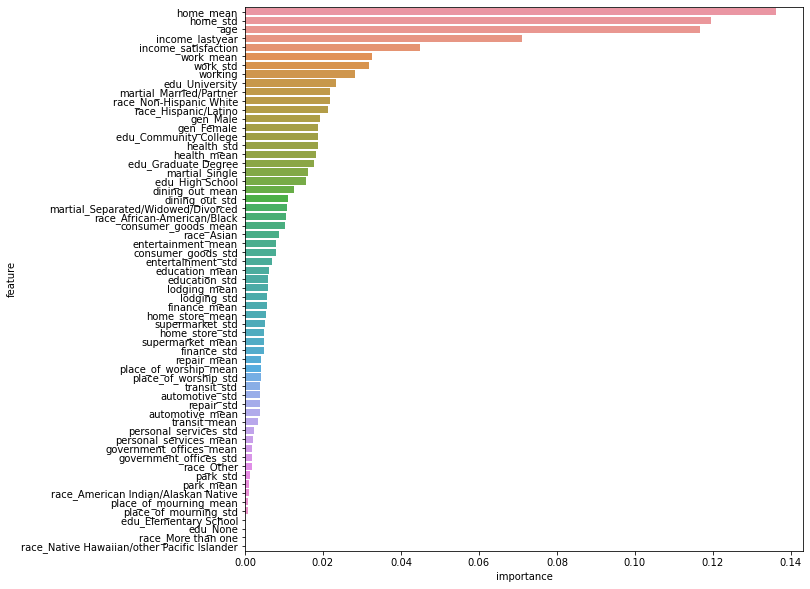

-------------------------
After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train set accuracy: 94.52%
Test set accuracy:  53.71%


In [18]:
from train import *

train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False,
      TEST_TAKE_FIRST=0, SEED=550, return_csv=False,
      feature_selection=True)

## 4 classes
Try 4 classes instead of 5 since the dataset is small:
- **0**:     Class 0 (None)
- **1-9**:   Class 1 (Mild = 1-4: Minimal, 5-9: Mild)
- **10-19**: Class 2 (Moderate = 10-14: Moderate, 15-19: Moderately severe)
- **20-27**: Class 3 (Severe = 20-27: Severe)

### Sanity check

In [36]:
# Create a list that is 0 for keys 0, 1 for keys 1-9, 2 for keys 10-19, 3 for keys 20-27
classes_list = [
    0 if i == 0 else 
    1 if i in range(1, 9+1) else 
    2 if i in range(10, 19+1) else
    3 if i in range(20, 27+1) else
    0 
    for i in range(0, 27+1)]
classes_dict = {i:v for i,v in enumerate(classes_list)}
classes_dict

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 3,
 21: 3,
 22: 3,
 23: 3,
 24: 3,
 25: 3,
 26: 3,
 27: 3}

In [37]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='classification', target='value', classes_dict=classes_dict)
phq9['target'].value_counts().sort_index()

0     195
1    2550
2    1735
3     311
Name: target, dtype: int64

In [38]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='regression', target='value')
counts = phq9['target'].value_counts().sort_index()
print(counts[0])
print(counts[1:9].sum())
print(counts[10:19].sum())
print(counts[20:27].sum())

195
2550
1735
311


### Results

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set accuracy: 96.45%
Test set accuracy:  69.71%


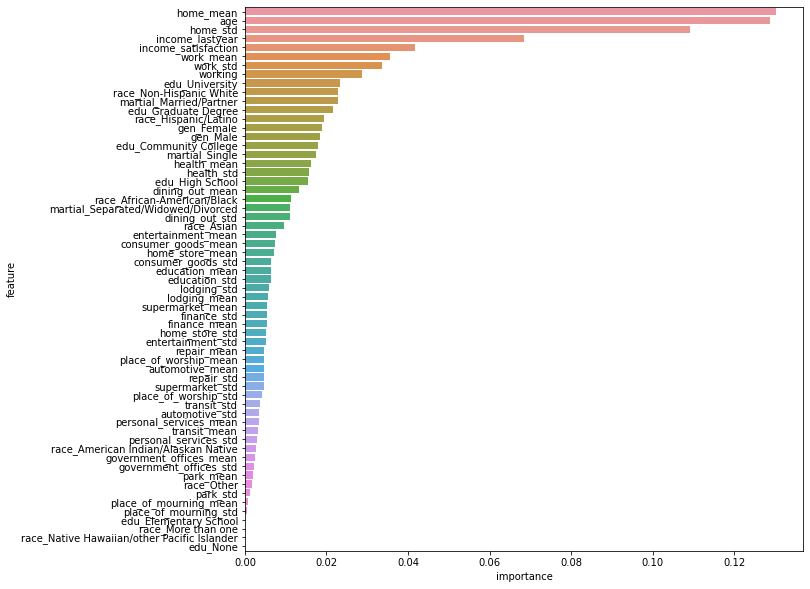

-------------------------
After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train set accuracy: 96.15%
Test set accuracy:  66.29%


In [39]:
train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False,
      TEST_TAKE_FIRST=0, SEED=550, return_csv=False, 
      feature_selection=True, classes_dict=classes_dict)

## 6 classes
The original classes

### Sanity check

In [40]:
classes_list = [ 
    1 if i in range(1, 4+1) else 
    2 if i in range(5, 9+1) else
    3 if i in range(10, 14+1) else
    4 if i in range(15, 19+1) else
    5 if i in range(20, 27+1) else
    0 
    for i in range(0, 27+1)]
classes_dict = {i:v for i,v in enumerate(classes_list)}
classes_dict

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 2,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 3,
 15: 4,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 5,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 26: 5,
 27: 5}

In [41]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='classification', target='value', classes_dict=classes_dict)
phq9['target'].value_counts().sort_index()

0     195
1     790
2    1760
3    1111
4     624
5     311
Name: target, dtype: int64

In [42]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='regression', target='value')
counts = phq9['target'].value_counts().sort_index()
print(counts[0])
print(counts[1:4].sum())
print(counts[5:9].sum())
print(counts[10:14].sum())
print(counts[15:19].sum())
print(counts[20:27].sum())

195
790
1760
1111
624
311


### Results

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set accuracy: 95.23%
Test set accuracy:  45.71%


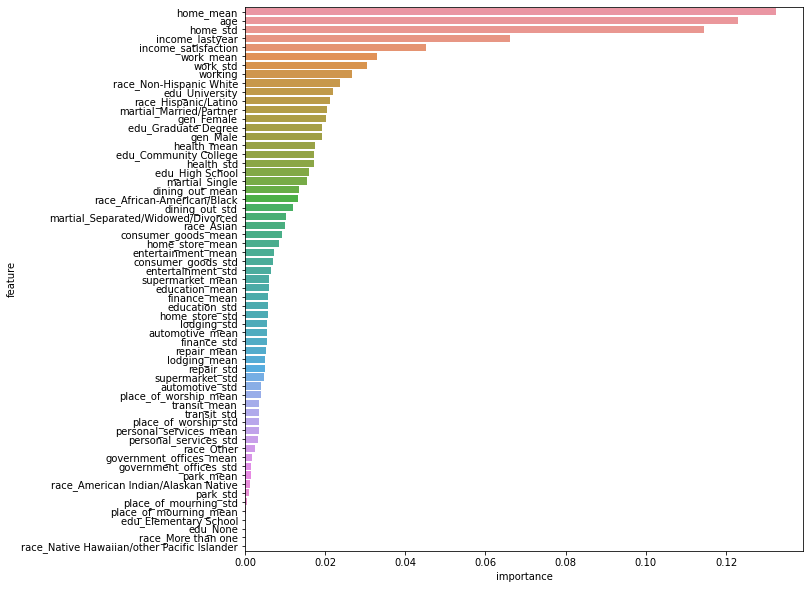

-------------------------
After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train set accuracy: 94.52%
Test set accuracy:  45.71%


In [43]:
train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0, SEED=550, return_csv=False, 
    feature_selection=True, classes_dict=classes_dict)

## 3 classes

### Sanity check

In [31]:
# Create a list that is 0 for keys 0-4, 1 for keys 5-9, 2 for keys 10-14, 3 for keys 15-27
classes_list = [
    0 if i in range(0, 4) else 
    1 if i in range(5, 14+1) else 
    2 if i in range(15, 27+1) else 
    0 
    for i in range(0, 27+1)]
classes_dict = {i:v for i,v in enumerate(classes_list)}
classes_dict

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 2}

In [28]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='classification', target='value', classes_dict=classes_dict)
phq9['target'].value_counts().sort_index()

0        5.0
1        7.0
2        4.0
3        5.0
4        5.0
        ... 
4786    10.0
4787    21.0
4788    14.0
4789     3.0
4790     9.0
Name: phq9_sum, Length: 4791, dtype: float64


0     985
1    2871
2     935
Name: target, dtype: int64

In [24]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='regression', target='value')
counts = phq9['target'].value_counts().sort_index()
print(counts[0:4].sum())
print(counts[5:14].sum())
print(counts[15:27].sum())


985
2871
935


Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set accuracy: 96.86%
Test set accuracy:  70.86%


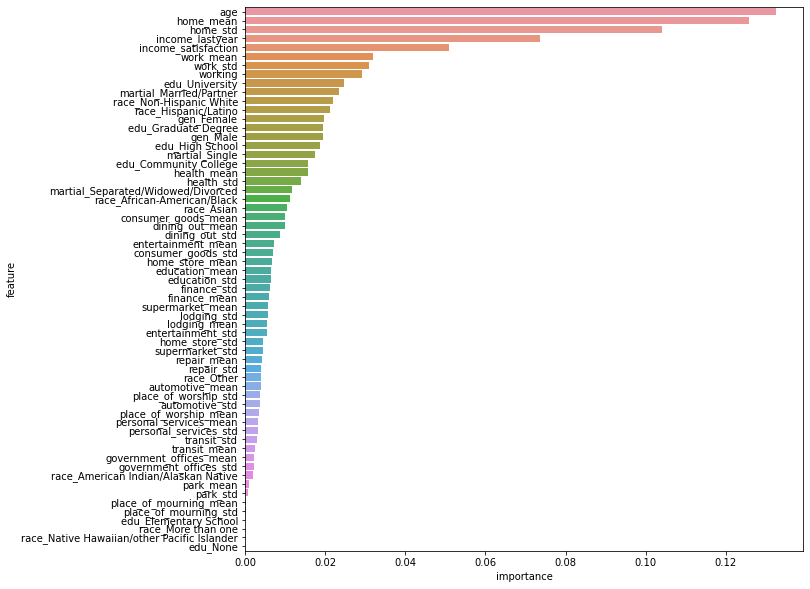

-------------------------
After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train set accuracy: 96.65%
Test set accuracy:  71.43%


In [26]:
train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0, SEED=550, return_csv=False, 
    feature_selection=True, num_classes=3)

## 4 classes

### Sanity check

In [32]:
# Create a list that is 0 for keys 0-4, 1 for keys 5-9, 2 for keys 10-14, 3 for keys 15-27
classes_list = [
    0 if i in range(0, 4) else
    1 if i in range(5, 9+1) else
    2 if i in range(10, 14+1) else
    3 if i in range(15, 27+1) else
    0
    for i in range(0, 27+1)]
classes_dict = {i:v for i,v in enumerate(classes_list)}
classes_dict

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 3,
 16: 3,
 17: 3,
 18: 3,
 19: 3,
 20: 3,
 21: 3,
 22: 3,
 23: 3,
 24: 3,
 25: 3,
 26: 3,
 27: 3}

In [33]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='classification', target='value', classes_dict=classes_dict)
phq9['target'].value_counts().sort_index()

0     985
1    1760
2    1111
3     935
Name: target, dtype: int64

In [34]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='regression', target='value')
counts = phq9['target'].value_counts().sort_index()
print(counts[0:4].sum())
print(counts[5:9].sum())
print(counts[10:14].sum())
print(counts[15:27].sum())

985
1760
1111
935


### Results

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set accuracy: 95.74%
Test set accuracy:  57.14%


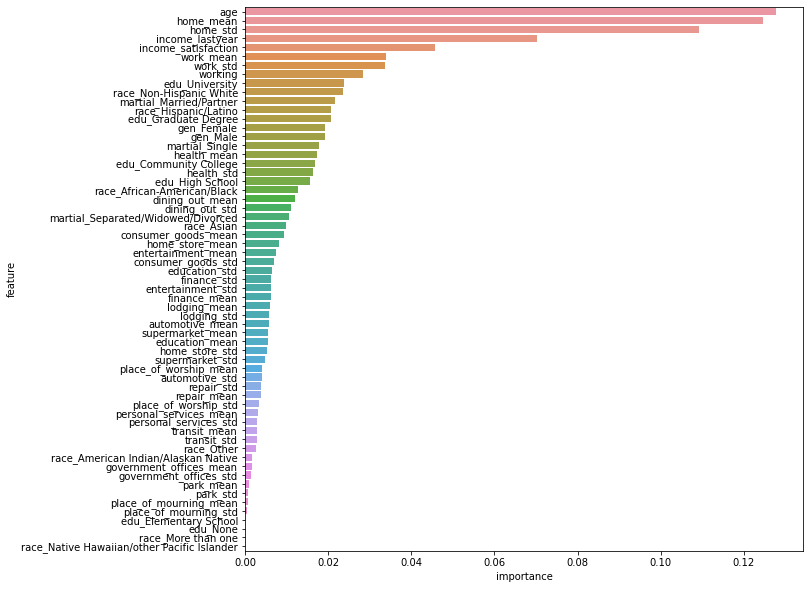

-------------------------
After feature selection:
Train set shape: (986, 24)
Test set shape: (175, 24)

Train set accuracy: 95.13%
Test set accuracy:  59.43%


In [35]:
train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False,
      TEST_TAKE_FIRST=0, SEED=550, return_csv=False, 
      feature_selection=True, classes_dict=classes_dict)

`num_classes=3` (0-4, 5-14, 15-27):
- train = 96.86%, test = 70.86% (no feature selection)
- train = 96.65%, test = 71.43% (feature selection)

`num_classes=4` (0, 1-9, 10-19, 20-27):
- train = 96.45%, test = 69.71% (no feature selection)
- train = 96.15%, test = 66.29% (feature selection)

`num_classes=4` (0-4, 5-9, 10-14, 15-27):
- train = 95.74%, test = 57.14% (no feature selection)
- train = 95.13%, test = 59.43% (feature selection)

`num_classes=5`:
- train = 94.52%, test = 50.29% (no feature selection)
- train = 94.52%, test = 53.71% (feature selection)

`num_classes=6` (0, 1-4, 5-9, 10-14, 15-19, 20-27):
- train = 95.23%, test = 45.71% (no feature selection)
- train = 94.52%, test = 45.71% (feature selection)

